# Linear Regression: Predicting miles-per-gallon usage in cars <img src="logo.png",width=140,height=140, align="right">

Begin by importing all necessary modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
%matplotlib inline 

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

mpl.style.available
mpl.style.use('ggplot') 


/opt/anaconda/envs/Python3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The data for this exercise consist 398 datapoints on car-specific features. It can be used to predict city-cycle fuel consumption in miles per gallon (mpg), and has 3 multivalued discrete and 4 continuous variables to use for the prediction. 

Variable Information:

1. mpg: continuous miles-per-gallon
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 
9. car name: string (unique for each instance)

Let's start by loading our original data file car_data.csv onto a data frame. Use pd.read_csv(...)

In [4]:
df = pd.read_csv('car_data.csv')

OK now that it's loaded, let's have a first look at the data using df.head()

In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Do you notice anything regarding the scale of the different features?
Now let's investigate this data

In [6]:
df.shape

(398, 9)

This says that we have 398 observations and 9 variables. We already know that our first variable (mpg) is our predictor variable Y, so that means that we have 8 features. However, let's disregard the name of the cars, as this is not a relevant feature we can use to predict mpg (can you think of why not?). Now let's check whether we have any missing values in our dataset

In [7]:
np.count_nonzero(df.isnull())   

6

Hmm ok, so that means that there are 6 instances in the dataset where a value is missing. Thankfully it's not too many cases, so let's do the easy thing and drop them. 

In [8]:
df=df.dropna(axis=0)
df.shape

(392, 9)

Great, so now that we dropped those missing values, let's have a first look at the thing we want to predict, miles-per-gallon. 

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

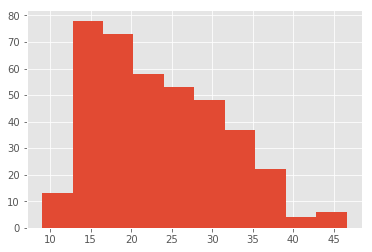

In [9]:
plt.hist(df.mpg, bins=10)
df.mpg.describe()

We can see that on average our cars use 23 miles-per-gallon (mpg), but that most of our observations are more in the 15-20 region. A standard deviation of 7 suggests that our observations are quite spread around the mean, and we can see that our cars vary from 9 to 46 miles per gallon in our dataset. 

Now let's start with plotting some relations between features and mpg in a scatter plot, to get a feel for our data. You can use plt.scatter() to plot horsepower against mpg, then weight against mpg

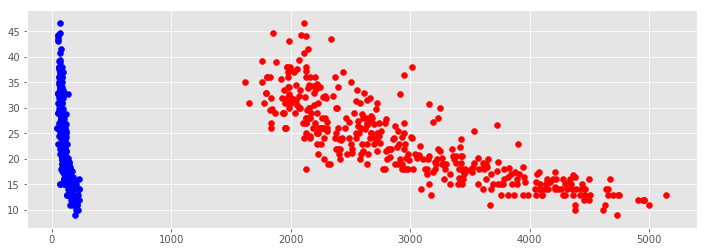

In [10]:
plt.figure(figsize=(12, 4))
plt.scatter(df['horsepower'],df['mpg'], c='b')
plt.scatter(df['weight'],df['mpg'], c='r')

Woa this looks funky, let's do something about the scale of our variables.

## Feature Scaling

If you look at our different car features, they are measured on very different scales. If we would ignore this, our optimization problem will take long to solve (as we will apply gradient descent on a very weird looking cost function) To make sure all our features are on the same scale, we will apply a little function to feature scale our features. You can also do this with Scikit-learn. 


Let's write our own function to scale features according to:

$$x_i = \frac{x_i - \mu_i}{std(x_i)}$$

You can use mean() and max() operators built into pandas to do this.
The function should return both the scaled input vector, as well as the mean and standard deviation to be used to scale future samples.
    

In [11]:
def FeatureScale(x):
    mu = x.mean()
    std = x.std()
    x_scaled = (x - mu) / std
    return x_scaled, mu, std

Scale both input features and store in new columns in data frame (also storing mean and standard deviation)

In [12]:
df['horsepower_scaled'],hp_mu, hp_std = FeatureScale(df.horsepower)
df['weight_scaled'], weight_mu, weight_std = FeatureScale(df.weight)
# Check that it work by printing the maximum values of the normal weight feature, and the scaled weight feature
print (df['weight'].max())
print (df['weight_scaled'].max())

5140
2.54580798087


OK cool, that worked

Now let's replot those two features using plt.scatter() to check the scaling effect

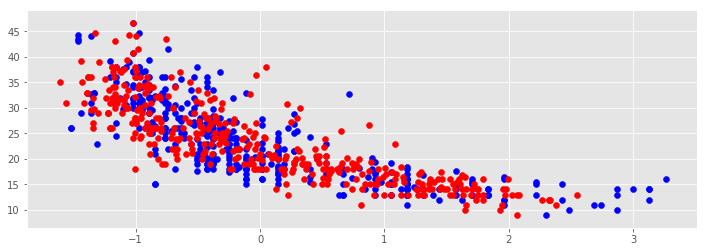

In [13]:
plt.figure(figsize=(12, 4))
plt.scatter(df.horsepower_scaled,df.mpg, c='b')
plt.scatter(df.weight_scaled,df.mpg, c='r')

Nice work! Now that we've done the feature scaling with our own function, let me show you how you can do it with an existing package. Let's start first by splitting up our data into our Y variable, or predictor variable, and our X variables, or our feature set X.

In [14]:
X = df.iloc[:, 1:8]
Y = df.iloc[:, 0]
# and let's check whether it worked by getting the shape of our feature set X
X.shape

(392, 7)

Great, that says our feature set is 398 by 7, i.e. it contains 398 observations of cars, with 7 different variables. Now before we can use our fancy scaler from Scikit-learn, we have to transform our feature set X to an array (i.e. a matrix). Right now X is a dataframe, so we can very simply change that with the commands below. 

In [16]:
# Let's transform our dataframe X to an array called features
features = np.array(X).astype(np.float)
# And let's save our feature names, as an array is a plain matrix without column names. These might come in handy later on
header = X.columns
# This is what it looks like right now
print (header, features)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year', 'origin'],
      dtype='object') [[   8.   307.   130.  ...,   12.    70.     1. ]
 [   8.   350.   165.  ...,   11.5   70.     1. ]
 [   8.   318.   150.  ...,   11.    70.     1. ]
 ..., 
 [   4.   135.    84.  ...,   11.6   82.     1. ]
 [   4.   120.    79.  ...,   18.6   82.     1. ]
 [   4.   119.    82.  ...,   19.4   82.     1. ]]


Super, now we're finally ready for our Scikit-learn magic, let's apply the scaler to our feature set

In [17]:
scaler  = preprocessing.StandardScaler().fit(features)
feat_scaled = scaler.transform(features)
print (feat_scaled)

[[ 1.48394702  1.07728956  0.66413273 ..., -1.285258   -1.62531533
  -0.71664105]
 [ 1.48394702  1.48873169  1.57459447 ..., -1.46672362 -1.62531533
  -0.71664105]
 [ 1.48394702  1.1825422   1.18439658 ..., -1.64818924 -1.62531533
  -0.71664105]
 ..., 
 [-0.86401356 -0.56847897 -0.53247413 ..., -1.4304305   1.63640964
  -0.71664105]
 [-0.86401356 -0.7120053  -0.66254009 ...,  1.11008813  1.63640964
  -0.71664105]
 [-0.86401356 -0.72157372 -0.58450051 ...,  1.40043312  1.63640964
  -0.71664105]]


OK, so now that we have scaled our features we're basically ready to start the regression-fun. Before we jump in with Scikit-learn regressions, let's get some intuition for what our regression model actually does. Let's look at the relation between weight and mpg, and let's try to fit a simple model on the weight and mpg scatter plot. 

In [18]:
# Our x variable is going to be weight, and our Y variable (expressed as a function of x , so f(x)) is mpg
x = df.weight_scaled

Define Linear Function :
$$f = \theta_0 + \theta_1 x$$

In [19]:
def LinFunc(x,theta0,theta1):
    f = theta0 + theta1*x
    return f

Choose values for $\theta_0$ and $\theta_1$, which we filled in already. Then use linfunc to predict labels (mpg values) for x. We'll save this as a new vector called 'Ypredicted'

In [20]:
theta0 = 20
theta1 = 0
Ypredicted = LinFunc(x,theta0,theta1)

Ypredicted is thus a simple line, with an intercept theta0 and a slope of theta1. Let's create a scatter plot and overlay our predictions using plt.plot(), we'll now see Ypredicted as a line over the real values in the scatter plot. 

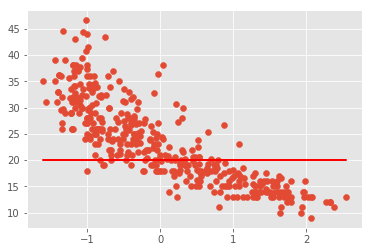

In [21]:
plt.scatter(x,Y)
plt.plot(x,Ypredicted, c='r')

OK that looks like a bad fit, our line does not seem to follow the patters at all, can you change the intercept and slope to get to a better fit to the data?

**Exercise:** Vary $\theta_0$ and $\theta_1$ parameters above and replot to get good fit

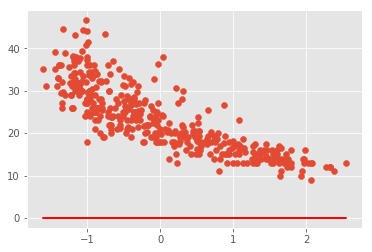

In [23]:
#change the values of theta0 and theta1 to better fit a line to the dots of observations
theta0 = #INSERT VALUE HERE
theta1 = #INSERT VALUE HERE
Ypredicted = LinFunc(x,theta0,theta1)
plt.scatter(x,Y)
plt.plot(x,Ypredicted, c='r')

Hopefully you've managed to get the model better fitting to the data. That should give you some intuition as to what a regression model does; it tries to find the best fitting model to the data it observes. Let's now let a machine learning algorithm show us how it's done. 

## Linear Regression with sklearn

So now that we have cleaned, investigated and scaled our data, we're ready for a linear regression using Scikit-Learn. Let's start by splitting our data into a training set and a test set. Scikit-Learn has a function for that we can use. You can learn more about it here: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [24]:
X_train, X_test, y_train, y_test = train_test_split(feat_scaled, Y, test_size=0.5, random_state=0)

test_size should be a value between 0 and 1, where the number is an indication for the percentage of train versus test data of the total sample size.

It doesn't matter if the random_state is set to 0 or 1 or any other integer. What matters is that it should be the same value each time you run the code, so your results stay the same should you run the code multiple times. You often see random_state=42 being used in official examples of scikit-learn.

Random_state, as the name suggests, is used for initializing the internal random number generator, which will decide the splitting of data into train and test indices in your case. 

The following function helps you get a nicely printed model with the variable names attached to the coefficients in the regression, we will use it later on

In [25]:
# Define a short function to get the model parameters and features printed (don't worry about understanding this code)
def pretty_print_linear(coefs, names, sort = False):
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 2), name)
                                   for coef, name in lst)

OK let's work our magic; let's take the LinearRegression model from Scikit-Learn and let's fit this model to our training data, and then we can print the coefficients of our model to see what it looks like

In [26]:
model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
# These are the standard settings for LinearRegression, you can therefore also just simply write model=LinearRegression()
model.fit(X_train, y_train)
print ("Our Linear Regression model is as follows: ", pretty_print_linear(model.coef_, header, sort=True))
print (model.coef_)

Our Linear Regression model is as follows:  -5.44 * weight + 2.84 * model_year + 1.38 * displacement + 1.08 * origin + 0.49 * acceleration + -0.46 * horsepower + -0.21 * cylinders
[-0.20761531  1.37858796 -0.45631464 -5.44220639  0.48742133  2.83734566
  1.08380278]


So do you understand how the model predicts observations? 

Let's have a look at the following observation, 
![alt text](example.png)

Could we use our model to directly predict miles-per-gallon usage of the Chevrolet Chevelle Malibu based on this? And would it be close to the actual mpg of 18?

Well, not it's not that simple. Remember we have scaled our features? So the coefficients of our model are only applicable to the scaled values. Moreover, we have set an intercept for the model, which we haven't displayed here. But with the intercept, the scaled features, and coefficients from our model, we could calculate the predicted values ourselves. But thankfully, Scikit-learn can do it for you! Below we calculate what the values of mpg our model would calculate for the test-part of the dataset. We can use that to compare our predicted mpg values to the actual mpg values, and assess how good our model is in predicting mpg values. 



In [27]:
# generate predicted values of mpg based on our model
predicted = model.predict(X_test)

Now that we have our predicted values, let's see how well they compare to the actual values. We'll look at three metrics to evaluate how well our model does. 

The R^2 (or R Squared) metric provides an indication of the goodness of fit of a set of predictions to the actual values. This is a value between 0 and 1 for no-fit and perfect fit respectively. Another way of interpreting R^2 is that it represents the % of the variation explained in the predicted variable Y, that can be attributed to features we used in the model. Let'se see what it looks like

In [28]:
print (metrics.r2_score(y_test, predicted))

0.821206237313


So about 80% of our the variation in mpg across cars can be explained by our 7 features, leaving only 20% of variation unexplained. This is not bad actually. 

The Mean Absolute Error (or MAE) is the sum of the absolute differences between predictions and actual values. It gives an idea of how wrong the predictions were. The closer to 0 this value is, the better. The measure gives an idea of the magnitude of the error, but no idea of the direction (e.g. over or under predicting).

In [29]:
print (metrics.mean_absolute_error(y_test, predicted))

2.52751926975


The Mean Squared Error (or MSE) is much like the mean absolute error in that it provides a gross idea of the magnitude of error.

Taking the square root of the mean squared error converts the units back to the original units of the output variable and can be meaningful for description and presentation. This is called the Root Mean Squared Error (or RMSE).

In [30]:
print (metrics.mean_squared_error(y_test, predicted)) 
RMSE= np.sqrt(metrics.mean_squared_error(y_test, predicted)) 
print (RMSE)

10.6474535415
3.26304360092


OK so now we have a RMSE of 3.3 and a mean absolute error of 2.5, is this any good? 
Let's put this into context by having another look at the description of our mpg variable.

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

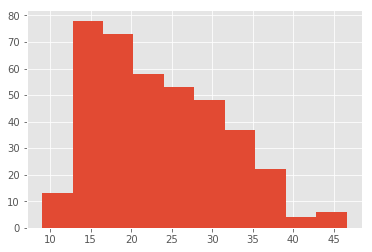

In [31]:
plt.hist(Y, bins=10)
Y.describe()

If we're getting predictions that on average vary 2.5-3 points from their actual value, that's not too bad. It's not super accurate, but at least it's smaller than our standard deviation of 7. 

Can you think of ways on how to improve the accuracy of our predictions? I.e. how to make the error smaller?

**Exercise:** Remember we split our data into half training data, half test data earlier on. Can you increase the % we use for training data and check what that does to our model error? What happens if you reduce the % of data used for training? 

## Appendix: Cross Validation

Remember in the first session we discussed cross-validation. We've done a one-off split between test and training data above, but it could very well be that our split determines the outcome of our model quite heavily. To test how robust your model is to the way it is split, you can do a more extensive cross-validation exercise. For example, you can do 5 or 10-fold cross validation. That means splitting your sample 5 or 10 times, refitting the model, recalculating the scores and looking at how your scores differ over your number of splits. Especially with smaller data sets, you may find that the way you have split your data will influence your results. Let's do an exercise where we recalculate our evaluation metrics across 10 different random splits. 

Scikit-learn has a model for this, which is straightforward to use. You assign a model, give it X and Y, number of times you want to repeat the cross-validation (cv). You can also designate a scorer object with the scoring parameter; All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error in our case, are available as neg_mean_squared_error which return the negated value of the metric. In order to get results comparable to our previous model, we simply multiply by -1. You can read more on what types of scorer objects are available for the different models here:

http://scikit-learn.org/stable/modules/model_evaluation.html

In [48]:
# evaluate the model using 10-fold cross-validation

scores = cross_val_score(LinearRegression(), X, Y, scoring='neg_mean_squared_error', cv=10)

# This returns the negative value of the mean squared error, let's calculate the RMSE to make it comparable to our previous model

print (np.sqrt(scores*-1))
print (np.sqrt(scores.mean()*-1))

[ 3.0964952   2.97904743  3.4019128   2.88170611  2.15938503  2.59762544
  4.29076282  3.54862838  5.5614548   3.85947014]
3.55780194387


In [49]:
scores = cross_val_score(LinearRegression(), X, Y, scoring='r2', cv=10)

print (scores)
print (scores.mean())


[ 0.6467103   0.77241016  0.59004729  0.7865709   0.80982887  0.83918792
  0.57751578  0.75474699  0.10028113  0.54874121]
0.64260405469


In [50]:
scores = cross_val_score(LinearRegression(), X, Y, scoring='neg_mean_absolute_error', cv=10)

print (scores*-1)
print (scores.mean()*-1)

[ 2.62506309  2.41938509  2.74317913  2.3843342   1.54245669  2.03655357
  3.51601891  2.8135498   4.07907701  3.04052009]
2.72001375778


**Exercise:** How do you think you can bring down the variance in scores achieved by the cross validation exercise?

## Appendix: Feature selection

In the slides we've discussed Ridge regression as a way to deal with collinearity. Also Lasso and ElasticNet were mentioned. The latter two are particularly usefull if you're dealing with a massive dataset, with loads and loads of features and you want to prevent overfitting 100s of futures in a model. These tools are quite usefull for that, as they penalize either large coefficient values, or large amounts of features. Ridge regression will force the coefficient values of relatively unimportant features down, Lasso can even force them to zero, and ElasticNet combines the penalties of both. I can recommend looking into these techniques, if you work a lot with regression models. On the implementation side, here is a good source for python code:

http://scikit-learn.org/stable/modules/linear_model.html

And below are some examples on how to implement these models

### Ridge regression
Ridge regression addresses some of the problems of a simple Ordinary Least Squares regression by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares,

$$\underset{w}{min\,} {{|| X w - y||_2}^2 + \alpha {||w||_2}^2}$$

Here, $\alpha \geq 0$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity. This is example of how to implement it on our data:

In [56]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

model = Ridge(alpha=50)
model.fit(X_train, y_train)
# generate evaluation metrics
predicted = model.predict(X_test)

print (metrics.r2_score(y_test, predicted))
print (metrics.mean_absolute_error(y_test, predicted))
print ("Ridge model:", pretty_print_linear(model.coef_, header, sort=True))

0.813028292557
2.54969042686
Ridge model: 0.75 * origin + 0.71 * model_year + -0.22 * cylinders + 0.06 * acceleration + -0.01 * horsepower + 0.01 * displacement + -0.01 * weight


### Lasso Regression

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. Under certain conditions, it can recover the exact set of non-zero weights.

Mathematically, it consists of a linear model trained with penalty $\ell_1$ prior as regularizer. The objective function to minimize is:
$$\underset{w}{min\,} { \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$$

The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha ||w||_1$ added, where $\alpha$ is a constant and $||w||_1$ is the $\ell_1$-norm of the parameter vector. Here's an example of how to implement it:

In [ ]:
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
model = Lasso(alpha=0.05)
model.fit(X_train, y_train)
# generate evaluation metrics
predicted = model.predict(X_test)

print (metrics.r2_score(y_test, predicted))
print (metrics.mean_absolute_error(y_test, predicted))
print ("Lasso model: ", pretty_print_linear(model.coef_, header, sort=True))

### Elastic-Net 

EN is a linear regression model trained with penalties L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.
A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

In [61]:
from sklearn.linear_model import ElasticNet

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

model = ElasticNet(alpha=0.05, l1_ratio=0.7)
model.fit(X_train, y_train)
predicted = model.predict(X_test)

print (metrics.r2_score(y_test, predicted))
print (metrics.mean_absolute_error(y_test, predicted))
print ("ElasticNet model: ", pretty_print_linear(model.coef_, header, sort=True))

0.816762668748
2.52242140294
ElasticNet model:  0.99 * origin + 0.71 * model_year + -0.26 * cylinders + 0.05 * acceleration + -0.01 * horsepower + 0.01 * displacement + -0.01 * weight


Copyright © ASI 2017 All rights reserved